# HANK NOT SURE IF WE WANT THAT
Creating a one-asset HANK with fiscal and monetary policy
From [link](https://github.com/shade-econ/sequence-jacobian/blob/master/notebooks/hank.ipynb)

In [1]:
from ConsIndShockModel_HANK_latest_12_14_2022_IncomeProcess import IndShockConsumerType
import sequence_jacobian as sj  # SSJ will allow us to define blocks, models, compute IRFs, etc
from sequence_jacobian.classes import JacobianDict, SteadyStateDict, UserProvidedSS
from sequence_jacobian import het, simple, create_model              # functions
from sequence_jacobian.blocks.block import Block
from sequence_jacobian.classes.result_dict import ResultDict
import matplotlib.pyplot as plt
import numpy as np
import pickle
import time

from scipy import optimize

In [2]:
# Defining steady state values of the economy
def fiscal_ss(B, r, G): 
    T = (1 + r) * B + G - B    
    return T

r_ss = 1.03 - 1
G_ss = .2
B_ss = 0.25 # this is lower than the tutorial by Straub et al. because need Higher MPC
Y_ss = 1.0
tau  = 0.0

T_ss = fiscal_ss(B_ss,r_ss,G_ss)
print('T_ss: ' +str(T_ss))

Z_ss = Y_ss - T_ss
C_ss = Y_ss - G_ss

print('Z_ss: ' +str(Z_ss))
print('C_ss: ' +str(Y_ss - G_ss))

T = 300 # Dimention of TxT Jacobian matrix

T_ss: 0.20750000000000002
Z_ss: 0.7925
C_ss: 0.8


In [3]:
# Defining a dictionary with parameter values. 
# Note: if you do not specify your own one, we'll provide you with some standard parameters.
Dict = {
    # Parameters shared with the perfect foresight model
    "CRRA":2,                              # Coefficient of relative risk aversion
    "Rfree": 1+r_ss,                    # Interest factor on assets
    "DiscFac": 0.96,                      # Intertemporal discount factor
    "LivPrb" : [.99375],                   # Survival probability
    "PermGroFac" : [1.00],                 # Permanent income growth factor

    # Parameters that specify the income distribution over the lifecycle
    "PermShkStd" : [.06],                  # Standard deviation of log permanent shocks to income
    "PermShkCount" : 7,                    # Number of points in discrete approximation to permanent income shocks
    "TranShkStd" : [0.3],                  # Standard deviation of log transitory shocks to income
    "TranShkCount" : 7,    
    
    # HANK params
    "taxrate" : [tau], # set to 0.0 because we are going to assume that labor here is actually after tax income
    "labor": [Y_ss - T_ss],
    "wage": [1.0],    
    
    # Number of points in discrete approximation to transitory income shocks
    "UnempPrb" : 0.0,                      # Probability of unemployment while working
    "IncUnemp" :  0.0,                     # Unemployment benefits replacement rate
    "UnempPrbRet" : 0.0000,                # Probability of "unemployment" while retired
    "IncUnempRet" : 0.0,                   # "Unemployment" benefits when retired
    "T_retire" : 0.0,                      # Period of retirement (0 --> no retirement)
    "tax_rate" : 0.0,                      # Flat income tax rate (legacy parameter, will be removed in future)

    # Parameters for constructing the "assets above minimum" grid
    "aXtraMin" : 0.0001,                    # Minimum end-of-period "assets above minimum" value
    "aXtraMax" : 1000, #1500,                       # Maximum end-of-period "assets above minimum" value
    "aXtraCount" : 500, #300,                     # Number of points in the base grid of "assets above minimum"
    "aXtraNestFac" : 3,                    # Exponential nesting factor when constructing "assets above minimum" grid
    "aXtraExtra" : [None],                 # Additional values to add to aXtraGrid

    # A few other parameters
    "BoroCnstArt" : 0.0,                   # Artificial borrowing constraint; imposed minimum level of end-of period assets
    "vFuncBool" : False,                   # Whether to calculate the value function during solution
    "CubicBool" : False,                   # Preference shocks currently only compatible with linear cFunc
    "T_cycle" : 1,                         # Number of periods in the cycle for this agent type 
    "cycles": 0,
    
    # Transition Matrix simulation parameters
    "mCount": 600,
    "mMax": 1000,
    "mMin": 0.0001,
    "mFac": 3,
}

In [4]:
# to add taxes, labor and wage
def function(taxrate, labor, wage):
    
    z = (1- taxrate)*labor*wage
    return z

Dict['TranShkMean_Func'] = function

In [5]:
# Creating our Agent
Agent = IndShockConsumerType(**Dict, verbose = False)

In [6]:
### Target only Steady State Asset
def ss_func(beta):
    Agent_func = IndShockConsumerType(**Dict, verbose = False)
    Agent_func.DiscFac = beta
    A_ss = Agent_func.compute_steady_state()[0]
    return A_ss
    

def ss_dif(beta):    
    return ss_func(beta) - Asset_target 

Asset_target = B_ss
DiscFac = optimize.brentq(ss_dif,.75,.99)

In [7]:
# Create a new agent
Dict['DiscFac'] = DiscFac
Agent_GE = IndShockConsumerType(**Dict, verbose = False)

In [8]:
A_ss, C_ss = Agent_GE.compute_steady_state()
MPC = Agent_GE.calc_jacobian('labor',T)[0][0][0]
print('Our general equilibrium agent has a discount rate of: ' +str(Agent_GE.DiscFac) +'. Where the steady state MPC is ' + str(MPC))

Our general equilibrium agent has a discount rate of: 0.9034953714546446. Where the steady state MPC is 0.2681125097703241


In [9]:
start = time.time()

CJACR_GE, AJACR_GE = Agent_GE.calc_jacobian('Rfree',T)
CJACN_GE, AJACN_GE = Agent_GE.calc_jacobian('labor', T)

print('Seconds to calculate Jacobian', time.time() - start)

Seconds to calculate Jacobian 12.870035648345947


In [10]:
HARK_SteadyState_Dict = SteadyStateDict({"C": C_ss, "r": r_ss, "Y": Y_ss, "B": B_ss, "G": G_ss, "A": A_ss})
HARK_Jacobian_Dict = JacobianDict( { 'C' : {'Z' : CJACN_GE, 'r': CJACR_GE} ,'A' : {'Z' : AJACN_GE, 'r': AJACR_GE} } ) 

In [11]:
@sj.simple
def fiscal(B, r, G, Y): 
    T = (1 + r) * B(-1) + G - B  # total tax burden
    Z = Y - T  # after tax income
    deficit = G - T
    
    return T, Z, deficit

@sj.simple
def mkt_clearing(A, B, Y, C, G):
    asset_mkt = A - B
    goods_mkt = C + G - Y
    
    return asset_mkt, goods_mkt

In [12]:
# Create the model and specify attributes
HARK_HANK = create_model([HARK_Jacobian_Dict, fiscal, mkt_clearing], name="HARK_HANK")
unknowns = ['Y']
targets = ['asset_mkt']
exogenous = ['G']

In [13]:
# First, we analyze a government spending shock.
G_std = .01
G_persistence = .8
dG =  G_std * G_persistence**np.arange(T)
shocks_G = {"G": dG}

In [14]:
# Create the IRFs
irfs_G = HARK_HANK.solve_impulse_linear(HARK_SteadyState_Dict, unknowns, targets, shocks_G)

In [15]:
def show_irfs(irfs_list, variables, labels=[" "], ylabel=r"Percentage points (dev. from ss)", T_plot=50, figsize=(18, 6)):
    if len(irfs_list) != len(labels):
        labels = [" "] * len(irfs_list)
    n_var = len(variables)
    fig, ax = plt.subplots(1, n_var, figsize=figsize, sharex=True)
    for i in range(n_var):
        # plot all irfs
        for j, irf in enumerate(irfs_list):
            ax[i].plot(100 * irf[variables[i]][:50], label=labels[j])
        ax[i].set_title(variables[i])
        ax[i].set_xlabel(r"$t$")
        if i==0:
            ax[i].set_ylabel(ylabel)
        ax[i].legend()
    plt.show()

In [16]:
# Deficit Spending
rho_B = 0.8
dB = np.cumsum(dG) * rho_B ** np.arange(T)
shocks_B = {'G': dG, 'B': dB}

irfs_B = HARK_HANK.solve_impulse_linear(HARK_SteadyState_Dict, unknowns, targets, shocks_B)

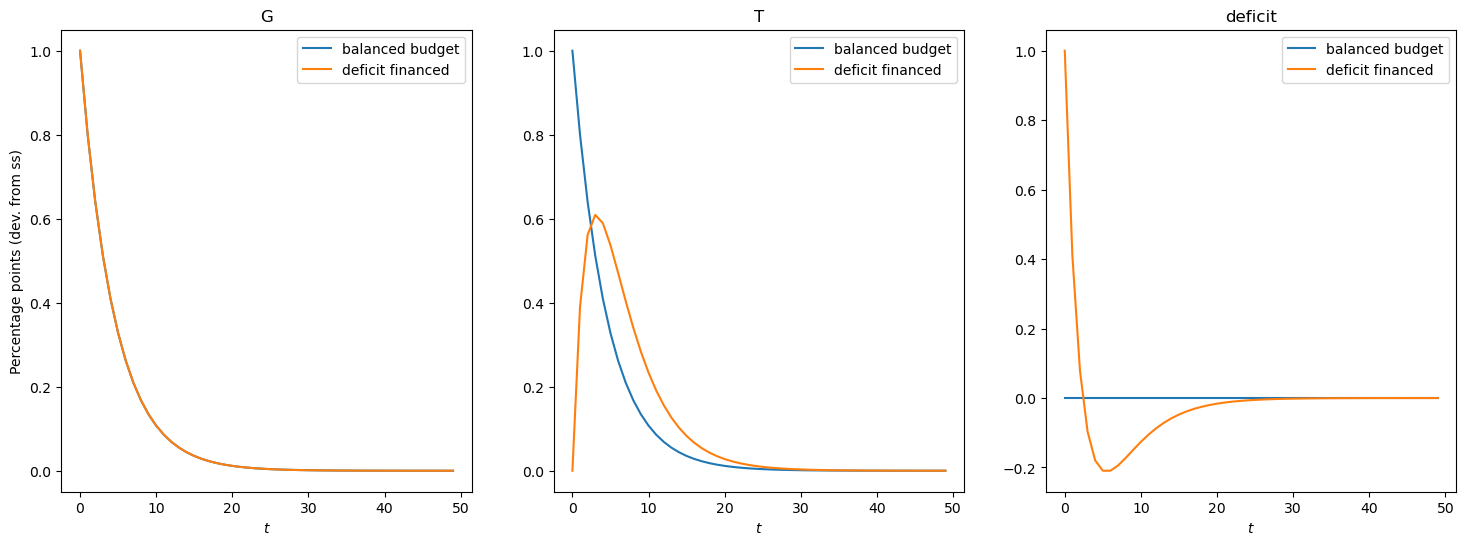

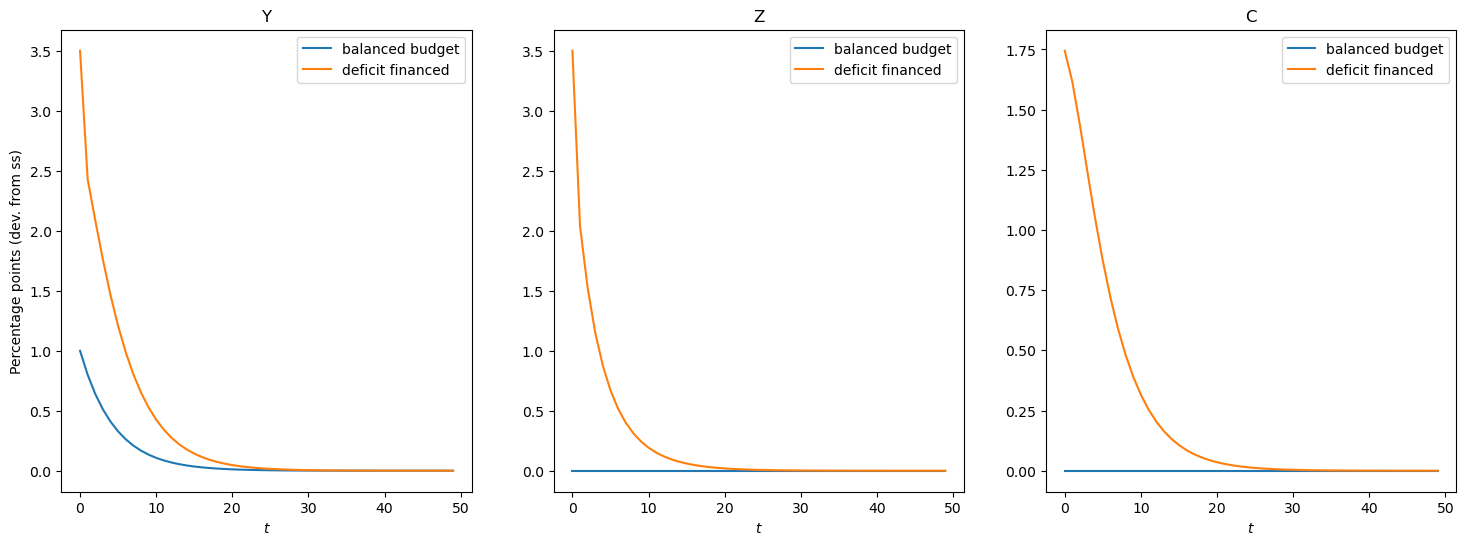

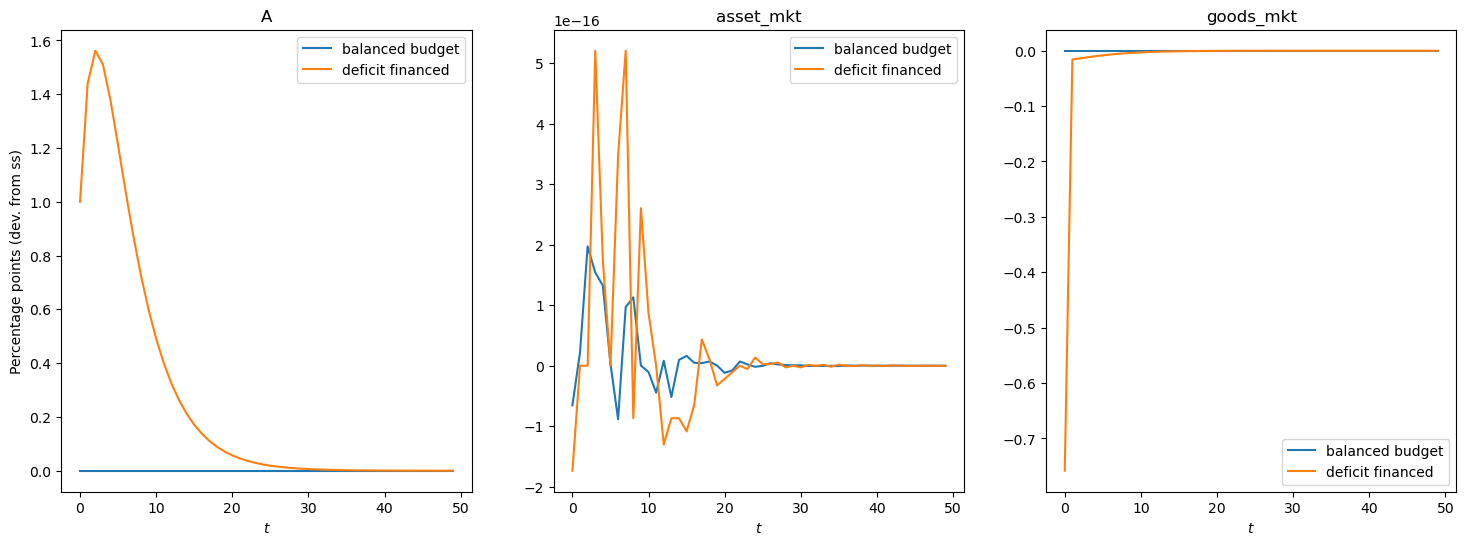

In [17]:
show_irfs([irfs_G, irfs_B], ['G', 'T', 'deficit'], labels=["balanced budget", "deficit financed"])
show_irfs([irfs_G, irfs_B], ['Y', 'Z', 'C'], labels=["balanced budget", "deficit financed"])
show_irfs([irfs_G, irfs_B], ['A', 'asset_mkt', 'goods_mkt'], labels=["balanced budget", "deficit financed"])